In [1]:
%load_ext autoreload
%autoreload 2

# from mfllowcli import _log_mlflow, _set_session
import pandas as pd
import pickle
# import json
import os
import s3fs
from pathlib import Path
import numpy as np

import seaborn as sns
from utils import reduce_memory
# from propmatch.mlflowcli import log_mlflow, pull_model

## Load Data

In [2]:
data = pd.read_parquet('./data/train/data.parquet')
X = pd.read_parquet('./data/train/X.parquet')
y = pd.read_parquet('./data/train/y.parquet').iloc[:, 0]

In [5]:
bool_cols = [c for c in X.columns if c.startswith('same')]
X = reduce_memory(X)

Mem. usage decreased to 42.05 Mb (0.0%% reduction)


In [7]:
X.dtypes

spatial                 float16
days                    float16
price_pct_diff          float16
partial_unit_score      float16
partial_street_score    float16
same_unit                  bool
same_building_id           bool
same_bin                   bool
same_complex               bool
candidates              float16
same_zipcode               bool
building_in_10             bool
same_unittype              bool
x                       float32
y                       float32
distance                float32
azimuth                 float16
dtype: object

## Load Model

In [8]:
import mlflow
tracking_uri = 'https://mlflow.production.streeteasy.cloud'

In [9]:
mlflow.set_tracking_uri(tracking_uri)

In [10]:
MODEL_NAME = 'expert_transaction_matching'
MODEL_VERSION = '12'

In [11]:
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{MODEL_NAME}/{MODEL_VERSION}")

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.sklearn
  run_id: 4bb2dade607043d2b1efb03d0fc10522

In [13]:
model = loaded_model._model_impl.sklearn_model

In [14]:
model

CalibratedClassifierCV(cv=4, ensemble=False,
                       estimator=Pipeline(steps=[('model',
                                                  LGBMClassifier(bagging_fraction=0.5913758206188472,
                                                                 boosting_type='dart',
                                                                 class_weight='balanced',
                                                                 colsample_bytree=None,
                                                                 feature_fraction=0.516377322490629,
                                                                 lambda_l1=0,
                                                                 lambda_l2=0,
                                                                 learning_rate=0.060621250695763136,
                                                                 min_child_samples=None,
                                                                 min_child_weight=27.36587626451878,
                                                                 min_data_in_leaf=2,
                                                                 min_sum_hessian_in_leaf=None,
                                                                 num_leaves=21,
                                                                 random_state=2024,
                                                                 reg_alpha=None,
                                                                 reg_lambda=None,
                                                                 subsample=None,
                                                                 subsample_for_bin=220000,
                                                                 verbose=-1))]))

## Predict

In [15]:
prob = model.predict_proba(X)[:, 1]

In [16]:
data['probability'] = prob

<Axes: >

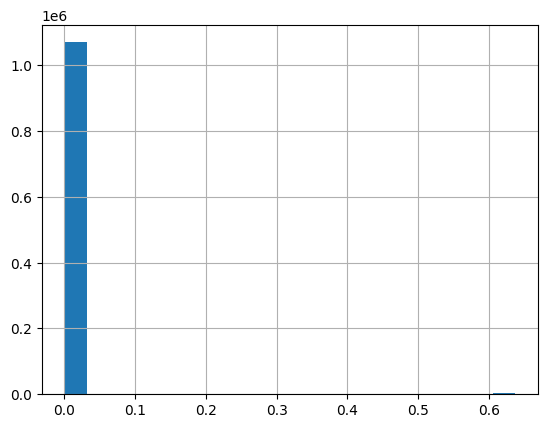

In [17]:
data['probability'].hist(bins=20)

## Review

In [18]:
cols = ['trxn_id', 'sale_id', 'probability','days','spatial', 'listing_unit',
        'listing_street', 'listing_zip',  'closing_unit', 
        'closing_street' , 'trxn_zip', 'trxn_price', 'listing_price']
# + features

In [19]:
mask = data['probability'] > 0.45

In [20]:
data['matched'] = data['sale_id'] == data['correct_sale_id']

In [21]:
data.loc[mask, 'matched'].mean()

0.6462948815889993

In [22]:
not_matched = data.correct_sale_id.isnull()

In [23]:
(mask & not_matched).sum()

1778

In [24]:
data[(mask & not_matched)].shape

(1778, 44)

In [25]:
data.loc[(mask & not_matched), 'trxn_id'].nunique()

1760

<Axes: >

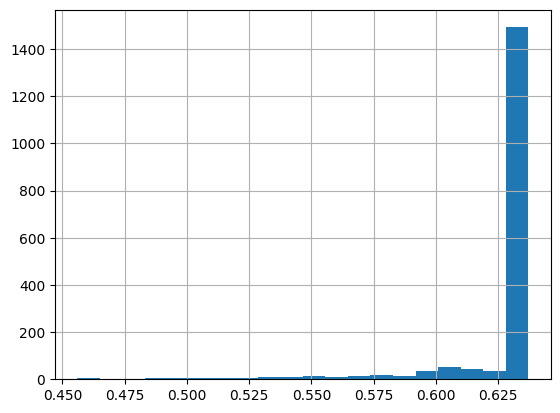

In [26]:
data.loc[(mask & not_matched), 'probability'].hist(bins=20)

### Look into it

In [27]:
data.loc[(mask & not_matched), cols].sort_values('probability', ascending=False).tail(10)

,trxn_id,sale_id,probability,days,spatial,listing_unit,listing_street,listing_zip,closing_unit,closing_street,trxn_zip,trxn_price,listing_price
1733,3037.0,1577219.0,0.489073,0.0,33.0,3H,269 BENNETT AVENUE,10040,3H,4523 Broadway,10040,371000.0,379000.0
83,73.0,1462140.0,0.486972,5.0,78.0,21H,330 EAST 33 STREET,10016,21H,330 East 33 Street,,585000.0,579000.0
1210,80.0,1451452.0,0.483270,-21.0,94.0,2F,259 BENNETT AVENUE,10040,2F,259 Bennett Avenue,,350000.0,355000.0
17,18.0,1398433.0,0.477066,40.0,135.0,11F,225 Adams Street,11201,11F,225 Adams Street,,510000.0,525000.0
203,6997.0,1687507.0,0.472499,-32.0,5.0,501,435 TOMPKINS AVENUE,11216,501,435 Tompkins Avenue,11216,758000.0,778000.0
1692,2998.0,1570904.0,0.464141,3.0,75.0,3CN,150 CHARLES STREET,10014,3CN,150 Charles,10014,4500000.0,4995000.0
3363,5173.0,1621456.0,0.462065,13.0,0.0,LC,3845 SHORE PARKWAY,11235,LC,"3845 Shore Parkway (#LC), Brooklyn, NY",11235,180000.0,189999.0
2604,3520.0,1601666.0,0.458487,-56.0,0.0,3,657 PROSPECT PLACE,11216,3,657 Prospect Place,11216,890000.0,849000.0
5391,6073.0,1661813.0,0.458487,-68.0,0.0,4A,83 UNDERHILL AVENUE,11238,4A,83 Underhill Avenue,11238,735000.0,699000.0
3625,5250.0,1639620.0,0.456040,-22.0,0.0,16,249 EAST 50 STREET,10022,16,249 East 50th Street,10022,3600000.0,3999900.0


In [43]:
data.loc[mask & (data.trxn_id == 5969), cols]

,trxn_id,sale_id,probability,days,spatial,listing_unit,listing_street,listing_zip,closing_unit,closing_street,trxn_zip,trxn_price,listing_price
63,5969.0,1657358.0,0.637151,0.0,0.0,12B,245 WEST 99 STREET,10025,12B,245 WEST 99 STREET,10025,4275000.0,4350000.0
64,5969.0,1657404.0,0.637151,0.0,0.0,12B,245 WEST 99 STREET,10025,12B,245 WEST 99 STREET,10025,4275000.0,4350000.0


In [28]:
data.loc[(mask & not_matched), 'trxn_id'].value_counts()

2685.0    2
7809.0    2
3780.0    2
4213.0    2
3562.0    2
         ..
3799.0    1
3702.0    1
3576.0    1
3597.0    1
245.0     1
Name: trxn_id, Length: 1760, dtype: int64

In [30]:
data.loc[(mask & not_matched), 'trxn_id'].nunique()

1760

In [31]:
data.loc[(mask & not_matched), 'trxn_id'].nunique() / data['trxn_id'].nunique()

0.29805249788314986

## Store

In [41]:
COLS = [
    'sale_id',
    'trxn_id',
    'trxn_price',
    'listing_price',
    'lottype_cat',
    'unittype_cat',
    'spatial',
    'days',
    'price_diff',
    'price_pct_diff',
    'partial_street_score',
    'partial_unit_score',
    'total',
    'same_zipcode',
    'listing_unit',
    'trxn_unit',
    'listing_street',
    'trxn_street',
    "trxn_zip",
    "trxn_city",
    "trxn_state",
    "listing_zip",
    "listing_city",
    "area_id",
    "building_in_10",
    "same_complex",
    "same_building_id",
    "same_block",
    "same_bin",
    "same_building_bbl",
    "same_bbl",
    "same_unittype",
    "candidates",
    "trxn_candidates",
    "model",
    "probability",
    "scored_at",
    
    
]

In [43]:
D = data.loc[(mask & not_matched), :].rename(columns={'closing_unit':'trxn_unit','closing_street':'trxn_street'})

In [44]:
D["model"] = MODEL_VERSION
D["scored_at"] = pd.Timestamp.now()

In [45]:
D = D[COLS]

In [46]:
D.shape

(1778, 37)

In [48]:
D.to_parquet('./data/result_backfill.parquet')